# Homework 2

Due: March 11<sup>th</sup>, 2016 (via pull request).

## Problem 1: The Field of Streams

Using the data from the SDSS catalog, and Python tools (e.g., matplotlib, numpy), make the analog of [Belokurov et al. 2006](http://iopscience.iop.org/1538-4357/642/2/L137/pdf/20450.web.pdf) "Field of streams" figure (Figure 1 in the paper):  

<img src="Belokurov+2006-Fig1.jpg" width="100%">

encompassing all DR12 data. Specifically:

* Write a query (either SQL or for LSD) to select stars satisfying the $g-r < 0.4$ color selection criterion (see Section 2 of Belokurov et al. 2006). You're free to either run this query against the [CasJobs SDSS database](http://skyserver.sdss.org/casjobs/), or the LSD copy of the database.

In [175]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import os
from lsd import DB
%matplotlib inline

*Set LSD environment variables:*

In [176]:
os.environ['NWORKERS'] = '8'
os.environ['LSD_CACHEDIR'] = os.environ['HOME'] + '/local/tmp/lsd_tmp'
os.environ['LSD_DIR'] = os.environ['HOME'] + '/local/tmp/lsd_tmp'
os.environ['LSD_DB'] = '/astro/apps6/opt/lsddb'

*Double-check that the sdss database is there:*

In [178]:
! ls /astro/apps6/opt/lsddb/

galex_gr5  sdss  twomass  usnob


*Confirm contents:*

In [179]:
! lsd-admin desc table sdss

Path:          /astro/apps6/opt/lsddb/sdss
Partitioning:  level=6
(t0, dt):      54335.000000, 1.000000 
Rows:          278674212
Columns:       33
Primary key:   sdss_id
Spatial keys:  (ra, dec)
Aliases:       []
Column groups: ['main', 'photometry', 'survey']
-------------------------------
Column group 'main':
              Column       Type
-------------------------------
             sdss_id         u8
                  ra         f8
                 dec         f8
                   l         f8
                   b         f8
                type         i4
               flags         i4
              flags2         i4
      resolve_status         i2
-------------------------------
-------------------------------
Column group 'photometry':
              Column       Type
-------------------------------
                   u         f4
                uErr         f4
                uExt         f4
              uCalib         i2
                   g         f4
                gE

*Using the LSD copy of the SDSS database, query stars satisfying the color cut (g-r < 0.4). I also need to select stars exclusively (type=6):*

In [180]:
rows = db.query('select sdss_id, ra, dec, g - gExt as g, r - rExt as r from sdss where (g-r < 0.4) & (type == 6)').fetch()

 [1606 el.]WARNING:lsd.pool2:Error contacting lsd-manager. Cannot coordinate resource usage with others, using 8 cores.
:::::::::::WARNING:lsd.pool2:Error contacting lsd-manager. Cannot coordinate resource usage with others, using 8 cores.
:::::::::>  59.75 sec


*Convert to table:*

In [181]:
field = Table(rows.as_ndarray())

*Check: how many objects did the query return?*

In [182]:
print len(field)

41619577


* Write Python code to divide the stars into the three r-band magnitude bins (see the paper and/or the figure caption for magnitude bin specification), and bin them into 0.5 deg x 0.5 deg pixels. You may find [numpy.histogram2d](http://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram2d.html) helpful.

*Use masks to make red, green, and blue r-band magnitude bins as described in Belokurov et al. 2006:*

In [183]:
#make ra_bins = np.arange(fieldmin,fieldmax,0.5) Do this for ra and dec
mask_r = (field['r'] > 21.33) & (field['r'] <= 22.0)
mask_g = (field['r'] > 20.66) & (field['r'] <= 21.33)
mask_b = (field['r'] >= 20.0) & (field['r'] <= 20.66)

*Make 0.5 deg x 0.5 deg pixels in RA and Dec. Create bins ranging from min to max RA/Dec in steps of 0.5 degrees:*

In [184]:
ra_bins = np.arange(field['ra'].min(),field['ra'].max(),0.5)
dec_bins = np.arange(field['dec'].min(),field['dec'].max(),0.5)

*Create 2D histograms in RA and Dec for each of the three color masks, and divide by (0.5)^2 to convert to pixels per square degree:*

In [185]:
hist_r = np.histogram2d(field['ra'][mask_r],field['dec'][mask_r],bins=[ra_bins,dec_bins])[0]/(0.5)**2
hist_g = np.histogram2d(field['ra'][mask_g],field['dec'][mask_g],bins=[ra_bins,dec_bins])[0]/(0.5)**2
hist_b = np.histogram2d(field['ra'][mask_b],field['dec'][mask_b],bins=[ra_bins,dec_bins])[0]/(0.5)**2

* Use [matplotlib.imshow](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.imshow) (or any other *Python* library of your choice) to create an RGB color composite equivalent of Figure 1. from the paper (see the figure caption for details)

*For plotting purposes, I need normalized density values between 0 and 1. Normalize the red, green and blue groups according to the density ranges given in Belokurov et al. 2006:*

In [186]:
# Red density range: 102-330
hist_r[hist_r > 330.] = 330.
hist_r[hist_r < 102.] = 102.
hist_r = (hist_r - 102.)/(330.-102.)

# Green density range: 107-304
hist_g[hist_g > 304.] = 304.
hist_g[hist_g < 107.] = 107.
hist_g = (hist_g - 107.)/(304.-107.)

# Blue density range: 98-267
hist_b[hist_b > 267.] = 267.
hist_b[hist_b < 98.] = 98.
hist_b = (hist_b - 98.)/(267.-98.)

*Combine the 2D density histograms for the three groups into a single RGB array to pass to imshow:*

In [187]:
hist_rgb = np.array([hist_r,hist_g,hist_b])

*Plot the result!*

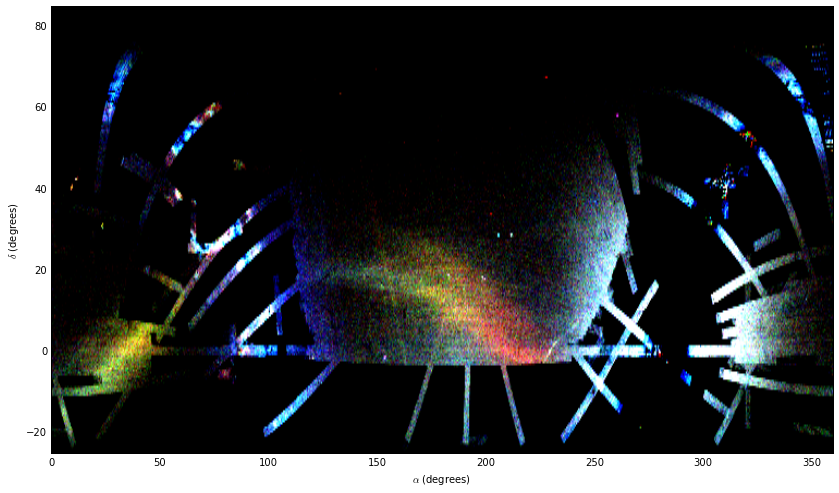

In [188]:
fig, ax = plt.subplots(figsize=(14,8))
img = ax.imshow(hist_rgb.T,origin='lower',extent=(ra_bins[0], ra_bins[-1], dec_bins[0], dec_bins[-1]), aspect='auto') #transpose rgb array
ax.set_xlabel(r'$\alpha$ (degrees)') 
ax.set_ylabel(r'$\delta$ (degrees)')

*Zoom in on the 'Field of Streams'. Reference the plot in Belokurov et al. 2006 to get appropriate axis limits.*

(-4, 60)

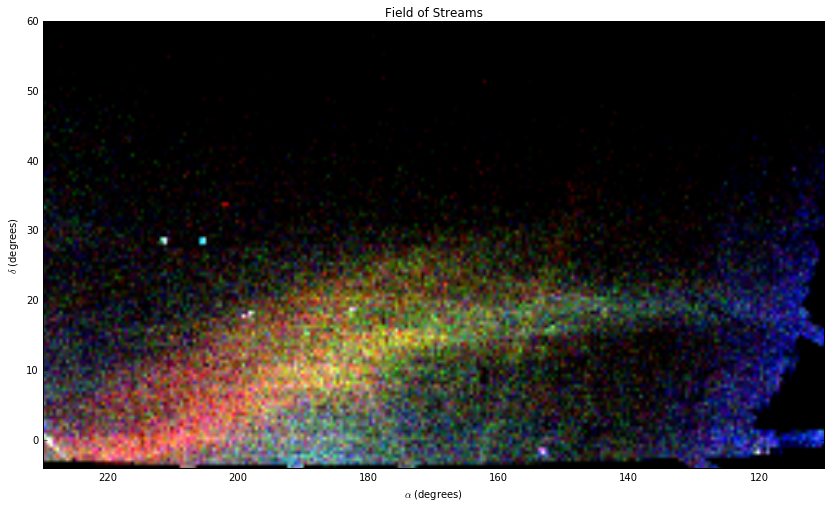

In [189]:
fig, ax = plt.subplots(figsize=(14,8))
img = ax.imshow(hist_rgb.T,origin='lower',extent=(ra_bins[0], ra_bins[-1], dec_bins[0], dec_bins[-1]), aspect='auto') #transpose rgb array
ax.set_xlabel(r'$\alpha$ (degrees)') 
ax.set_ylabel(r'$\delta$ (degrees)')
ax.set_title('Field of Streams')
ax.set_xlim(230,110)
ax.set_ylim(-4,60)

*Gaze in wonder. So cool!*